In [32]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K


In [33]:
# read in data 
data = pd.read_csv('testdata2.csv', index_col = 0)
train, test = train_test_split(data, test_size = 0.05, shuffle = False)

In [34]:
class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='tanh')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data):
        data = pd.DataFrame(data, columns=['0', '1', '2', '3', '4', '5'])
        #print(type(pricesPa))
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([data.values[1:], data.pct_change().values[1:] ], axis=1)

        #print('made it1')
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)

        #print('made it2')
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))

        #print('made it3')
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=10, shuffle=False)
        return self.model.predict(fit_predict_data)[0]

In [35]:
def calculateWeights(pricePath, running_weights_paths, historydays):
    mod = Model()
    return mod.get_allocations(pricePath)

In [36]:
class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()
        self.running_weights_paths = [[1/6, 1/6, 1/6, 1/6, 1/6, 1/6]]
        
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        ### edit: used np.append to make this work
        self.running_price_paths = np.append(self.running_price_paths, asset_prices)
    
        ### TODO Implement your code here
        #print(self.running_price_paths)
        
        historydays = 40
        
        paths1 = self.running_price_paths[-historydays * 6:].T
        pricePaths = []
        for i in range(historydays):
            sub = paths1[i*6: i*6+6]
            pricePaths.append(sub)
        #pricePaths = np.array(pricePaths)
        pricesPaths = pd.DataFrame(pricePaths, columns=['0', '1', '2', '3', '4', '5'])
        #pricePaths = pd.DataFrame({'0': data[:, 0], '1': data[:, 1], '2': data[:, 2], '3': data[:, 3], '4': data[:, 4], '5': data[:, 5]})
        
            
        weights = calculateWeights(pricePaths, self.running_weights_paths, historydays)
        self.running_weights_paths.append(weights)
        
        return weights
    
    
    
def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

Epoch 1/10


/Users/sabrinavan/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: -0.0907
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0368
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0699
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0859
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0958
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1026
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1073
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1107
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1133
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1152
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: -0.0431
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: -0.0579
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: -0.0723
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: -0.0862
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: -0.0990
Epoch 6

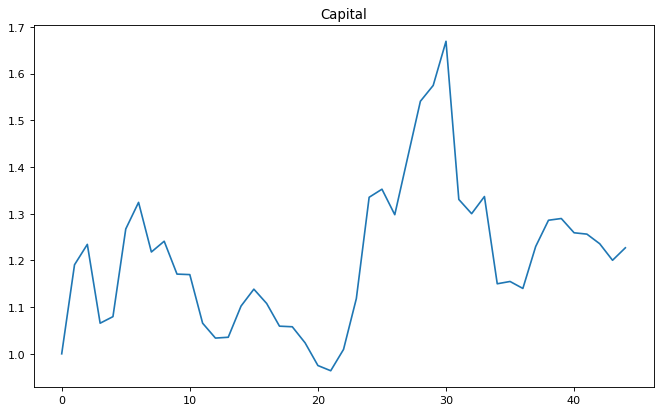

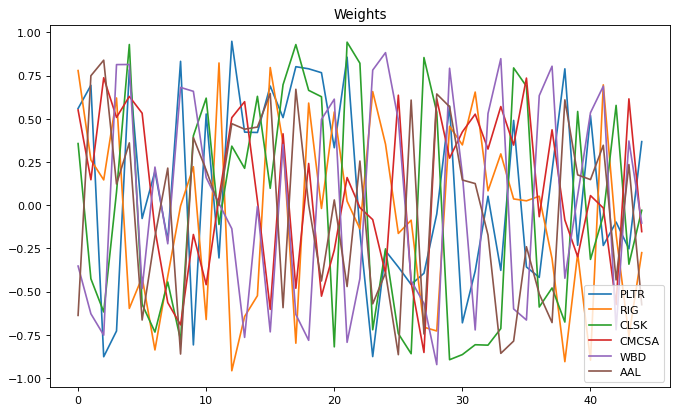

In [37]:
# run simulation
sharpe, capital, weights = grading(train, test)
print(sharpe)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(test)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(test)), weights)
plt.legend(test.columns)
plt.show()